# Deep Convolutional Generative Adversarial Networks with TensorFlow

 In this tutorial, we will try to build a GAN that is able to generate human faces with TensorFlow. Sounds scary, doesn’t it?


## Setup

Used Libraries:
* matplotlib
* PIL / Pillow
* numpy
* requests
* tqdm
* TensorFlow

A helper function will automatically download the CelebA dataset to get you up and running quickly. Be sure to have matplotlib installed to actually see the images. The download is 1.7GB large, so be sure to have enough disk space and a stable internet connection ready.

## The CelebA Dataset

The CelebFaces Attributes Dataset dataset contains over 200,000 celebrity images each with 40 attribute annotations. At this point, we are also going to define to function for batch generation. This function will load our images and give us an array of images according to a batch size we are going to set later. To get some better results, we will crop the images, so that only the faces are showing. We will also normalize the images so that their values are in a range from -0,5 to +0,5. At last, we are going to downscale the images to 28x28 after that.

In [28]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot as plt
from skimage import io
from PIL import Image
import numpy as np
import helper
import random

# Image configuration
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
data_dir = '/Users/nils/CC/afm-cnn/data/raw'
data_files = glob(os.path.join(data_dir, '*.tif'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 1

In [3]:
shape

(4006, 512, 512, 1)

In [4]:
len(io.imread(data_files[0],as_grey=True).shape)
iw,ih=io.imread(data_files[0],as_grey=True).shape

In [5]:
def get_image(image_path):
    """
    Read image from image_path
    """
    img = io.imread(image_path,as_grey=True)

    return img

def get_batch(image_files):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file) for sample_file in image_files]).astype(np.float32)

    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255

    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5
        
def n_imshow(img_list):
    n = len(img_list)
    plt.figure(figsize=(20,60))
    for i in range(n):
        plt.subplot(1,n,i+1), plt.imshow(np.squeeze(img_list[i]),cmap='viridis')

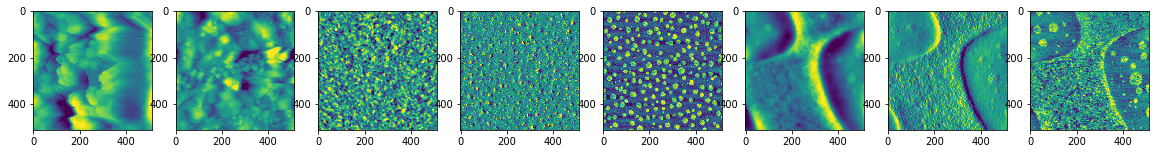

In [6]:
test_images = get_batch(data_files[:9])
# plt.imshow(test_images[0])
n_imshow(test_images[:8])

## Defining network input

Before we can start defining our two networks, we are going to define our inputs. We are doing this to not clutter the training function any more than it already is. Here, we are simply defining TensorFlow Placeholders for our real and fake inputs and for the learning rate.

In [48]:
if 35 in [int(35/2), 35]:
    print(1)

1


In [7]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

## The discriminator network

The discriminator is the “art critic”, who tries to distinguish between real and fake images. Simply said, this is a convolutional neural network for image classification. The discriminator network consists of four convolutional layers. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [8]:
def discriminator(images, net={}, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        net['conv1'] = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        net['lrelu1'] = tf.maximum(alpha * net['conv1'], net['conv1'])
        
        # Conv 2
        net['conv2'] = tf.layers.conv2d(net['lrelu1'], 128, 5, 2, 'SAME')
        net['batch_norm2'] = tf.layers.batch_normalization(net['conv2'], training=True)
        net['lrelu2'] = tf.maximum(alpha * net['batch_norm2'], net['batch_norm2'])
        
        # Conv 3
        net['conv3'] = tf.layers.conv2d(net['lrelu2'], 256, 5, 2, 'SAME')
        net['batch_norm3'] = tf.layers.batch_normalization(net['conv3'], training=True)
        net['lrelu3'] = tf.maximum(alpha * net['batch_norm3'], net['batch_norm3'])
       
        # Flatten
        net['flat'] = tf.reshape(net['lrelu3'], (-1, 64*64*256))
        
        # Logits
        net['logits'] = tf.layers.dense(net['flat'], 1)
        
        # Output
        net['out'] = tf.sigmoid(net['logits'])
        
        return net['out'], net['logits'], net

## The generator network

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of four deconvolutional layers. In here, we are doing the same as in the discriminator, just in the other direction. First, we take our input, called Z, and feed it into our first deconvolutional layer. Each deconvolutional layer performs a deconvolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [9]:
def generator(z, out_channel_dim, net={}, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        net['x_1'] = tf.layers.dense(z, 64*64*256)
        
        # Reshape it to start the convolutional stack
        net['deconv_2'] = tf.reshape(net['x_1'], (-1, 64, 64, 256))
        net['batch_norm2'] = tf.layers.batch_normalization(net['deconv_2'], training=is_train)
        net['lrelu2'] = tf.maximum(alpha * net['batch_norm2'], net['batch_norm2'])
        
        # Deconv 1
        net['deconv3'] = tf.layers.conv2d_transpose(net['lrelu2'], 256, 5, 2, padding='SAME')
        net['batch_norm3'] = tf.layers.batch_normalization(net['deconv3'], training=is_train)
        net['lrelu3'] = tf.maximum(alpha * net['batch_norm3'], net['batch_norm3'])
        
        # Deconv 2
        net['deconv4'] = tf.layers.conv2d_transpose(net['lrelu3'], 128, 5, 2, padding='SAME')
        net['batch_norm4'] = tf.layers.batch_normalization(net['deconv4'], training=is_train)
        net['lrelu4'] = tf.maximum(alpha * net['batch_norm4'], net['batch_norm4'])
        
        # Deconv 3
        net['deconv5'] = tf.layers.conv2d_transpose(net['lrelu4'], 64, 5, 2, padding='SAME')
        net['batch_norm5'] = tf.layers.batch_normalization(net['deconv5'], training=is_train)
        net['lrelu5'] = tf.maximum(alpha * net['batch_norm5'], net['batch_norm5'])
        
        # Output layer
        net['logits'] = tf.layers.conv2d_transpose(net['lrelu5'], out_channel_dim, 5, 2, padding='SAME')
        
        net['out'] = tf.tanh(net['logits'])
        
        return net['out'], net

In [26]:
import random
random.shuffle(data_files)
data_files

['/Users/nils/CC/afm-cnn/data/raw/2736.tif',
 '/Users/nils/CC/afm-cnn/data/raw/170.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3439.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3690.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3004.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1669.tif',
 '/Users/nils/CC/afm-cnn/data/raw/2645.tif',
 '/Users/nils/CC/afm-cnn/data/raw/617.tif',
 '/Users/nils/CC/afm-cnn/data/raw/2038.tif',
 '/Users/nils/CC/afm-cnn/data/raw/2523.tif',
 '/Users/nils/CC/afm-cnn/data/raw/838.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3970.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1276.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1416.tif',
 '/Users/nils/CC/afm-cnn/data/raw/673.tif',
 '/Users/nils/CC/afm-cnn/data/raw/972.tif',
 '/Users/nils/CC/afm-cnn/data/raw/2242.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1216.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3929.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1243.tif',
 '/Users/nils/CC/afm-cnn/data/raw/1.tif',
 '/Users/nils/CC/afm-cnn/data/raw/3488.tif',
 '/Users/nils/CC/a

## Loss Functions

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model, _ = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real, _ = discriminator(input_real)
    d_model_fake, d_logits_fake, _ = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

## Optimization

Rather than just having a single loss function, we need to define three: The loss of the generator, the loss of the discriminator when using real images and the loss of the discriminator when using fake images. The sum of the fake image and real image loss is the overall discriminator loss.

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Visualization

In the last step of our preparation, we are writing a small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [12]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    n_imshow(samples[:8])

## Training

Now, we just get our inputs, losses and optimizers which we defined before, call a TensorFlow session and run it batch per batch. Every 400 steps we are printing out the current progress by showing the generated image and loss. Now lean back and see the faces show up slowly but steady - and we mean slowly but steady! This progress can take up some hours based on your setup.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])


## Section to test the network

In [15]:
tf.reset_default_graph()

z_dim = 100
input_real, input_z, _ = model_inputs(shape[1], shape[2], shape[3], 100)
out_disc, log_disc, net_disc = discriminator(input_real)
out_gen, net_gen = generator(input_z, 1)

for batch_images in get_batches(2):
    print('iteration')
    with tf.Session() as sess:
        
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter("logs", sess.graph)

        init=tf.global_variables_initializer()
        sess.run(init)
        
        out1 = sess.run(net_disc,feed_dict = {input_real:batch_images})
        out2 = sess.run(net_gen, feed_dict = {input_z:np.random.rand(1,z_dim)})
        sess.close()
    
    break


iteration


In [20]:
print([{i:out2[i].shape} for i in out2.keys()])

[{'x_1': (1, 1048576)}, {'deconv_2': (1, 64, 64, 256)}, {'batch_norm2': (1, 64, 64, 256)}, {'lrelu2': (1, 64, 64, 256)}, {'deconv3': (1, 128, 128, 256)}, {'batch_norm3': (1, 128, 128, 256)}, {'lrelu3': (1, 128, 128, 256)}, {'deconv4': (1, 256, 256, 128)}, {'batch_norm4': (1, 256, 256, 128)}, {'lrelu4': (1, 256, 256, 128)}, {'deconv5': (1, 512, 512, 64)}, {'batch_norm5': (1, 512, 512, 64)}, {'lrelu5': (1, 512, 512, 64)}, {'logits': (1, 1024, 1024, 1)}, {'out': (1, 1024, 1024, 1)}]


In [21]:
print([{i:out1[i].shape} for i in out1.keys()])

[{'conv1': (2, 256, 256, 64)}, {'lrelu1': (2, 256, 256, 64)}, {'conv2': (2, 128, 128, 128)}, {'batch_norm2': (2, 128, 128, 128)}, {'lrelu2': (2, 128, 128, 128)}, {'conv3': (2, 64, 64, 256)}, {'batch_norm3': (2, 64, 64, 256)}, {'lrelu3': (2, 64, 64, 256)}, {'flat': (2, 1048576)}, {'logits': (2, 1)}, {'out': (2, 1)}]


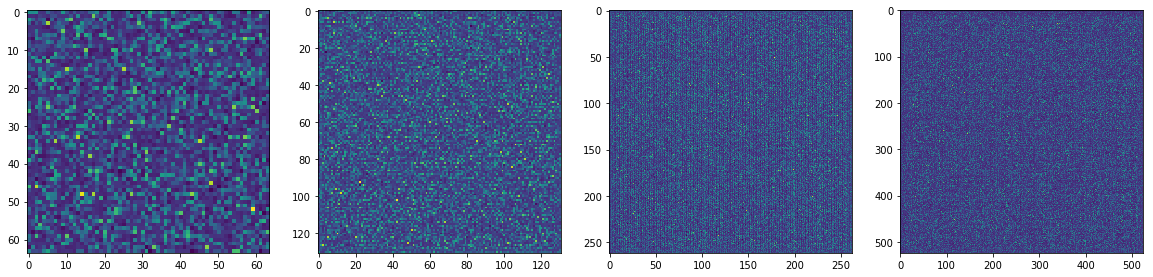

In [179]:
n_imshow([out2[k][0,:,:,0] for k in list(out2.keys())[3::3]])

In [208]:
io.imsave('test_gen_out.png',out2['out'][0,:,:,0])

/anaconda/envs/pyTen/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [209]:
tf.trainable_variables()

[]

In [187]:
batch_size = 2
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)b
    

KeyboardInterrupt: 

In [196]:
d_train_opt

NameError: name 'd_train_opt' is not defined

In [185]:
8786432/512

17161.0

In [86]:
np.random.rand(100)

array([ 0.42792057,  0.49554427,  0.55666873,  0.07597299,  0.26669305,
        0.52875365,  0.08771632,  0.7180703 ,  0.48859492,  0.20680355,
        0.44996322,  0.95161778,  0.02735494,  0.84110089,  0.45530057,
        0.91870386,  0.6363652 ,  0.26747052,  0.78943918,  0.38912984,
        0.5857696 ,  0.13621142,  0.79041956,  0.51506506,  0.34356922,
        0.39633583,  0.40496633,  0.76710188,  0.61745334,  0.87122927,
        0.08820066,  0.85236629,  0.24382862,  0.985953  ,  0.27058564,
        0.66196713,  0.88869569,  0.02595623,  0.95040525,  0.60617677,
        0.58649545,  0.90766064,  0.84238559,  0.74655443,  0.47718296,
        0.35874333,  0.91043993,  0.65068528,  0.59618225,  0.8792011 ,
        0.33359912,  0.57015261,  0.05137827,  0.40408317,  0.97249556,
        0.89947704,  0.98741144,  0.02278658,  0.42257982,  0.5404334 ,
        0.94876949,  0.31389515,  0.69402077,  0.18040762,  0.56895626,
        0.42726404,  0.9105361 ,  0.64199693,  0.55523749,  0.28

In [42]:
print([net[i].shape for i in net.keys()])

[(2, 256, 256, 64), (2, 256, 256, 64), (2, 128, 128, 128), (2, 128, 128, 128), (2, 128, 128, 128), (2, 64, 64, 256), (2, 64, 64, 256), (2, 64, 64, 256), (2, 1048576), (2, 1), (2, 1)]


In [82]:
net['logits']

array([[-1.56753111],
       [-0.59381735]], dtype=float32)

In [43]:
64*64*256

1048576

In [44]:
out

array([[ 0.15786764],
       [ 0.83761424]], dtype=float32)

In [130]:
tensor_2d = np.array(np.random.rand(4, 4), dtype='float32')
tensor_2d_1 = np.array(np.random.rand(4, 4), dtype='float32')
tensor_2d_2 = np.array(np.random.rand(4, 4), dtype='float32')

m1 = tf.convert_to_tensor(tensor_2d)
m2 = tf.convert_to_tensor(tensor_2d_1)
m3 = tf.convert_to_tensor(tensor_2d_2)
mat_product = tf.matmul(m1, m2)
mat_sum = tf.add(m2, m3)
mat_det = tf.matrix_determinant(m3)

with tf.Session() as session:
    print(session.run(mat_product))
    print( session.run(mat_sum))
    print( session.run(mat_det))

[[ 2.00064635  1.08308363  1.17677999  1.46601653]
 [ 0.62203032  0.84056288  0.24450743  0.41404402]
 [ 1.1207366   0.77851391  0.76284754  0.83430421]
 [ 1.6484251   1.00620782  1.04092515  1.29015625]]
[[ 1.17108774  0.28402174  1.04847991  1.48371434]
 [ 1.09951019  0.3974762   1.62884259  1.20643175]
 [ 0.26499003  1.63689649  0.0613538   0.74635303]
 [ 1.28540874  0.97978044  0.8015734   1.56873012]]
0.0784406


In [131]:
m1

<tf.Tensor 'Const:0' shape=(4, 4) dtype=float32>

In [132]:
m2

<tf.Tensor 'Const_1:0' shape=(4, 4) dtype=float32>

In [133]:
mat_product

<tf.Tensor 'MatMul:0' shape=(4, 4) dtype=float32>

In [134]:
descriminator

NameError: name 'descriminator' is not defined

In [139]:
tf.layers.conv2d(tf.expand_dims(tf.expand_dims(m1,0),-1),1,2)

<tf.Tensor 'conv2d_2/BiasAdd:0' shape=(1, 3, 3, 1) dtype=float32>